In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mogli
import os
from ipywidgets import IntProgress
from IPython.display import display, clear_output
from PIL import Image

from src.CameraPoseVisualizer import CameraPoseVisualizer
import numpy as np

import importlib
import json

In [2]:
bandgaps = np.loadtxt('Datasets/bandgaps.csv')
cods = np.loadtxt('Datasets/CODids.csv', dtype=int)
materials = mogli.read('Datasets/structures.xyz')

In [3]:
def circle(radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    z = np.zeros_like(theta)
    # put x,y, and z as columns in a matrix

    return np.column_stack((x.flatten(), y.flatten(), z.flatten()))
# x = circle(100, 20)

# plt.figure(figsize=(10,10))
# plt.plot(x[:,0], x[:,1], 'o')


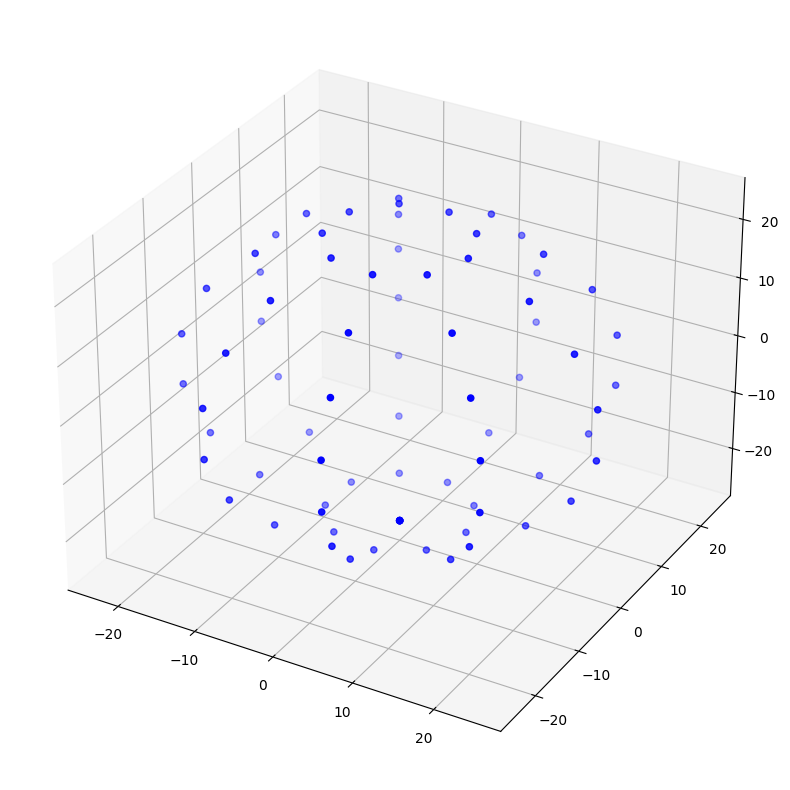

In [4]:
def sphere (radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    phi = np.linspace(0, np.pi, n)
    x = radius*np.outer(np.cos(theta), np.sin(phi)).flatten()
    y = radius*np.outer(np.sin(theta), np.sin(phi)).flatten()
    z = radius*np.outer(np.ones(np.size(theta)), np.cos(phi)).flatten()
    
    
    mask = np.logical_and(x != 0, y != 0)
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    # print(x.shape)
    
    return np.column_stack((x,y,z))
# s = sphere(25, 10)
# # plot points
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(s[:,0], s[:,1], s[:,2], c='b', marker='o')

In [5]:
class Cameraframe():
    def __init__(self,filePath,transform_matrix, sharpness=5725):
        self.file_path = filePath
        self.sharpness= sharpness
        self.transform_matrix = transform_matrix
    def toJson(self):
        return {
            "file_path": self.file_path,
            # "sharpness": self.sharpness,
            "transform_matrix": self.transform_matrix.tolist()
        }
    
class dataset():
    def __init__(self, w, h ,angle_degrees = 45):        
        self.camera_angle_x= np.radians(angle_degrees)
        self.camera_angle_y= np.radians(angle_degrees)   
        self.w= w
        self.h= h
        self.frames = []
    def toJson(self):
        return {
            "camera_angle_x": self.camera_angle_x,
            "camera_angle_y": self.camera_angle_y,           
            "cx": self.w / 2,
            "cy": self.h / 2,
            "w": self.w,
            "h": self.h,
            "frames": [frame.toJson() for frame in self.frames]             
        }
    def save(self, path):
        with open(path, 'w') as outfile:
            json.dump(self.toJson(), outfile)
        

initialize camera pose visualizer


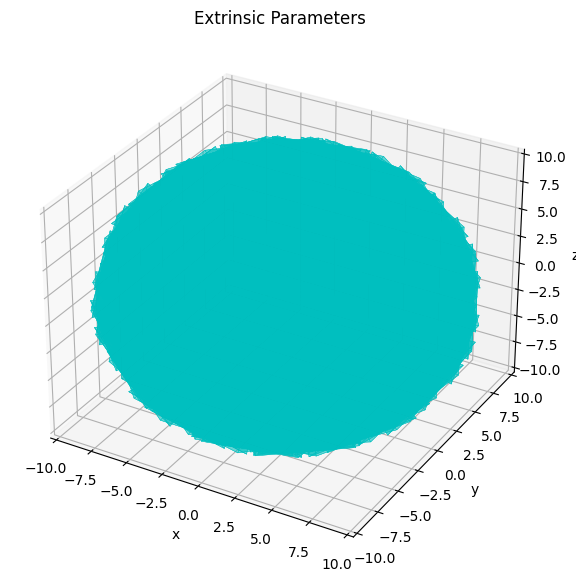

Traceback (most recent call last):
  File "e:\Github\band-gap\instant-ngp\scripts\run.py", line 25, in <module>
    import pyngp as ngp # noqa
ModuleNotFoundError: No module named 'pyngp'


In [6]:
bonds_param = 1.5
width = 100
height = 100
distance = 25
formatFile = "jpg"
train_steps = 1000

importlib.reload(mogli)
path = f'Datasets/3d/{width}x{height}_BP{bonds_param}/'
if not os.path.exists(path):
    os.makedirs(path)    
for i, molecule in enumerate(materials):
    # if i == 0 :
    #     continue
    pathmolecule = f'{path}/{i}'
    if not os.path.exists(pathmolecule):
        os.makedirs(pathmolecule)   
    Nerf = dataset(width,height)
    data  = {}
    sp = sphere(distance, 15)
    
    data["poses"] = np.zeros((sp.shape[0],4,4),dtype=np.float32)
    data["images"] = np.zeros((sp.shape[0],width,height,3 if formatFile == "jpg" else 4),dtype=np.float32)
    data["focal"] = np.array(np.tan(np.radians(45) * 0.5),dtype=np.float32)    
    
    for n , (x,y,z) in enumerate(sp):
              
        img_path = f"{pathmolecule}/molecula_x_{i}_{n}.{formatFile}"
        camerapos = np.array([x,y,z])
        camera = mogli.export(molecule,img_path,bonds_param=bonds_param,camera=((x,y,z),(0, 0, 0),(0 , 0 , 1)), width=width, height=height).T
        camera[:3,3] =  camerapos / distance
        img =  Image.open(img_path)
        data["poses"][n] = camera
        data["images"][n] = np.array(img)/255.0
        
        Nerf.frames.append(Cameraframe(f"molecula_x_{i}_{n}.{formatFile}",camera))
    Nerf.save(f"{pathmolecule}/nerf.json")   
            
    visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-10, 10])

    for pose in data["poses"]:
        visualizer.extrinsic2pyramid(pose, 'c', 10)
    visualizer.show()   
    
    snapshot_path = os.path.join(pathmolecule, f"{train_steps}.ingp")
    !python ./instant-ngp/scripts/run.py {pathmolecule} --n_steps {train_steps} --save_snapshot {snapshot_path}
    np.savez(f"{pathmolecule}/dataf.npz", **data)
    break

In [7]:

x = r"Datasets\3d\100x100_BP1.5\0\volume_raw\256x256x256_0.bin"
#read file 
data =None
with open(x, "rb") as f:
    data = f.read()

data = np.frombuffer(data, dtype=np.float16)


FileNotFoundError: [Errno 2] No such file or directory: 'Datasets\\3d\\100x100_BP1.5\\0\\volume_raw\\256x256x256_0.bin'

In [ ]:
data = data.reshape((256,256,256,8))
data.shape